
# A point analysis of weak learning models

    Notebook version: 1.1 (Feb 2, 2017)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
               

    Changes: v.1.0 - First version

In [11]:
# To visualize plots in the notebook
%matplotlib inline 

# Import some libraries that will be necessary for working with data and displaying plots
# import csv     # To read csv files
# import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
# from sklearn import neighbors, datasets
import wlc.WLweakener2 as wlw


## 1. Introduction.

In this notebook we analyze the behavior of sample based estimates of a $C$-dimensional probability vector $\boldsymbol{\eta}$ from binary vector instances.

The main goal is to compare the behavior of a "supervised" estimate, based on a set of labels $\{{\bf y}_k, k=0,\ldots, K-1\}$ generated from $\boldsymbol{\eta}$, and estimates based on weak labels, $\{{\bf b}_k, k=0,\ldots, K-1\}$, generated from some related distribution ${\bf q} = {\bf M}\boldsymbol{\eta}$, where ${\bf M}$ is called a mixing matrix and contains conditional probabilities.

To do so, we will generate a dataset of labels drawn from $\boldsymbol{\eta}$, and one or more datasets of weak labels drawn from ${\bf q}$.

First we define some configurable parameters:

Mixing matrix:
[[ 0.6  0.2  0.2]
 [ 0.2  0.6  0.2]
 [ 0.2  0.2  0.6]]


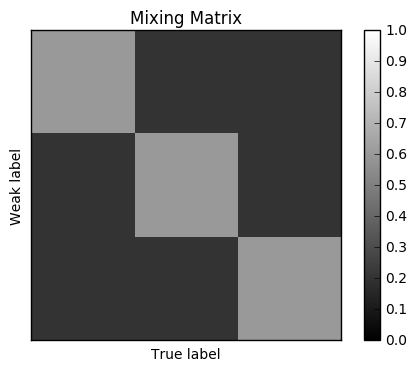

In [28]:
C = 3                             # Number of classes
K = 10000                          # Sample size
eta = np.array([0.5, 0.2, 0.3])   # True probability vector

# Mixing matrix
M = wlw.computeM(C, beta=0.5, method='quasi_IPL')
M = wlw.computeM(C, beta=0.4, method='noisy')
M = M[np.sum(M, axis=1) > 0]   # This is to remove zero rows, which are not relevant

# Show:
print "Mixing matrix:"
print M
plt.imshow(M, interpolation='nearest', cmap="gray", clim=(0.0, 1.0)) 
plt.colorbar()
plt.title('Mixing Matrix')
plt.xlabel('True label')
plt.ylabel('Weak label')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### 1.1. Dataset generation.

In the following we will generate a dataset of labels and their corresponding weak labels

In [29]:
# Generate true labels
I = np.eye(C)
iy = np.random.choice(np.arange(0, C), size=K, p=eta)
y = I[iy]

# Generate weak label indices
iz = wlw.generateWeak(iy, M, C)

### 1.2. Supervised, sample based estimation.

In the supervised setting, ${\bf y}$ is observed an the optimal sample based estimate of $\boldsymbol{\eta}$ (minimizing any Bregmann divergence) based on the observed labels is the sample average

In [30]:
f = np.mean(y, axis=0)
print "Supervised estimate: {0}".format(f)
e2 = np.mean((f - eta)**2)
print "Square error: {0}".format(e2)

Supervised estimate: [ 0.4877  0.1988  0.3135]
Square error: 0.00011166


### 1.3. Learning from weak labels.

There are many ways to estimate $\boldsymbol{\eta}$ from the weak labels. We consider here a representative sample of them:

#### 1.3.1. Averaging virtual labels

If ${\bf z}$ is a sample from distribution ${\bf q}$, and ${\bf V}$ is any left inverse of the mixing matrix (so that ${\bf V}{\bf M} = {\bf I}$ then it can be shown that $\mathbb{E}\{{\bf v}\} = \boldsymbol{\eta}$. Therefore, we can estimate $\boldsymbol{\eta}$ as the average of virtual labels:

In [31]:
# v = wlw.computeVirtual(iz, C, method='quasi_IPL')
v = wlw.computeVirtual(iz, C, M=M, method='Mproper')
print "Virtual labels are:"
print v
f_v = np.mean(v, axis=0)

print "Virtual label estimate: {0}".format(f_v)
e2 = np.mean((f_v - eta)**2)
print "Square error: {0}".format(e2)

Virtual labels are:
[[-0.5  2.  -0.5]
 [ 2.  -0.5 -0.5]
 [ 2.  -0.5 -0.5]
 ..., 
 [ 2.  -0.5 -0.5]
 [ 2.  -0.5 -0.5]
 [-0.5 -0.5  2. ]]
Virtual label estimate: [ 0.494  0.193  0.313]
Square error: 8.46666666667e-05


#### 1.3.2. Maximum Likelihood Estimate

(This section is deprecated. I have proved that the ML estimate is actually equivalent to the average of the virtual label vector, so there is no reason to take time for the analysis of this estimate. However. I preserve the section because it provides a first test of the behavior of the EM estimation method).


In [35]:
def computeML(iz, M, f0=None, max_iter=1e10, echo='off'):
    """
    Compute the ML estimate of a probability vector based on weak labels in iz and the mixing matrix M.
    The estimation method is based on Expectation Maximization.
    """

    # Initialize the estimate.
    if f0 is None:
        C = M.shape[1]   # No. of classes
        f_ml = np.ones(C)/C
    else:
        f_ml = f0

    # Recursive estimation
    iterate = True
    count = 0
    while iterate:
        fi = np.dot(np.diag(f_ml), M.T)[:,iz.astype(int)]
        fi = fi / np.sum(fi, axis=0)
        f_new = np.mean(fi, axis=1)
        count += 1
        iterate = np.any(f_new != f_ml) and count < max_iter
        f_ml = np.copy(f_new)
    
    if echo=='on':
        if count>= max_iter:
            print "Stopped before convergence after {0} iterations".format(max_iter)
        else:
            print "Converged in {0} iterations".format(count)

    return f_ml

def computeNLL(iz, M, f):
    """
    Compute the Log-Likelihood function for an estimate f.
    """
    
    I = np.eye(M.shape[0])
    z = I[iz.astype(int)]
    NLL = - np.dot(np.mean(z, axis=0), np.log(np.dot(M, f)))

    return NLL


We can verify that the EM steps monotonically decrease the NLL

[ 0.494  0.193  0.313]
[ 0.3976  0.2772  0.3252]
[ 0.494  0.193  0.313]
[ 0.5  0.2  0.3]


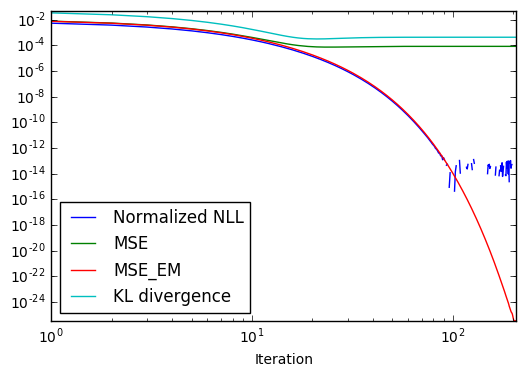

The final estimate is [ 0.494  0.193  0.313]
The true label is [ 0.5  0.2  0.3]


In [33]:
n_it = 1000

f = None
NLL = []
MSE = []
KL = []
MSE_EM = []

I = np.eye(M.shape[0])
z = I[iz.astype(int)]
q = np.mean(z, axis=0)

for i in range(n_it):
    
    f_new = computeML(iz, M, f, max_iter=1)
    
    if f is not None and np.all(f_new == f):
        break
    else:
        f = np.copy(f_new)

    NLL.append(computeNLL(iz, M, f) + np.dot(q, np.log(q)))
    MSE.append(np.mean((f - eta)**2))
    KL.append(- np.dot(eta, np.log(f)) + np.dot(eta, np.log(eta)))
    MSE_EM.append(np.mean((f - f_v)**2))

print f
print q
print f_v
print eta
its = range(len(NLL))
plt.loglog(its, NLL, label= "Normalized NLL")
plt.loglog(its, MSE, label= "MSE")
plt.loglog(its, MSE_EM, label= "MSE_EM")
plt.loglog(its, KL, label= "KL divergence")
plt.legend(loc='best')
plt.axis('tight')
plt.xlabel('Iteration')
plt.show()
print "The final estimate is {0}".format(f)
print "The true label is {0}".format(eta)


In [42]:
f_ml = computeML(iz, M, max_iter=100000, echo='on')

print "ML estimate: {0}".format(f_ml)
e2 = np.mean((f_ml - eta)**2)
print "Square error: {0}".format(e2)

Converged in 221 iterations
ML estimate: [ 0.5025  0.1905  0.307 ]
Square error: 4.85000000001e-05


## 2. Statistical analysis of the MSE.

We will compute all estimates multiple times in order to compare the distribution of the MSE.

First, to make sure that the WLL estimate is working properly, we plot the convergence of the estimate with the number of iterations

In [92]:
n_sim = 100
mse = {'wll': []}
K = 1000
for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print '\r Simulation {0} out of {1}'.format(str(n+1), n_sim),
    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I[iy]

    # Generate weak label indices
    iz = wlw.generateWeak(iy, M, C)
    # Estimation with virtual labels
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.cumsum(v, axis=0) / np.arange(1, K+1)[:,np.newaxis]

    mse_n = np.mean((f_v - eta)**2, axis=1)
    mse['wll'].append(mse_n)

 Simulation 100 out of 100


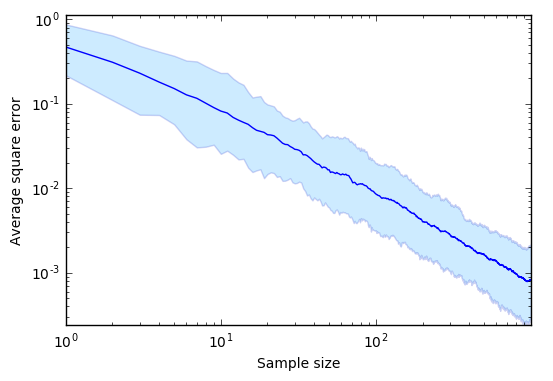

In [93]:
mse_mean = np.mean(mse['wll'], axis=0)
d = mse['wll'] - mse_mean
mse_std_u = np.sqrt(np.sum(d**2*(d >=0), axis=0)/np.sum((d >=0), axis=0))
mse_std_d = np.sqrt(np.sum(d**2*(d <=0), axis=0)/np.sum((d <=0), axis=0))
plt.fill_between(range(K), mse_mean - mse_std_d, mse_mean + mse_std_u,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=1, linestyle='solid', antialiased=True)
plt.loglog(range(K), mse_mean)
plt.axis('tight')
plt.xlabel('Sample size')
plt.ylabel('Average square error')
plt.show()

### 2.1. Supervision vs partial supervision

In the following we test, for a fixed sample size, the estimation of $\boldsymbol{\eta}$ as the average of virtual labels, in comparison with a complete supervision, as the average of the true labels.

In [45]:
n_sim = 100
mse = {'sup': [], 'wll': []}

for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print '\r Simulation {0} out of {1}'.format(str(n+1), n_sim),

    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I[iy]

    # Generate weak label indices
    iz = wlw.generateWeak(iy, M, C)

    # Supervised estimation
    f = np.mean(y, axis=0)
    mse['sup'].append(np.sum((f - eta)**2))

    # Estimation with virtual labels
    # v = wlw.computeVirtual(iz, C, method='quasi_IPL')
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.mean(v, axis=0)
    mse['wll'].append(np.mean((f_v - eta)**2))

 Simulation 100 out of 100


The following error plots shows, that, under very weak supervision, there is a significant performance degradation caused by the use of weak labels.

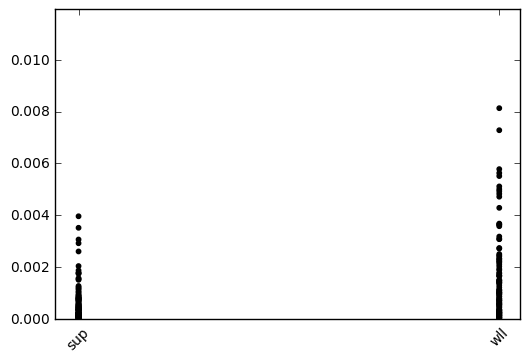

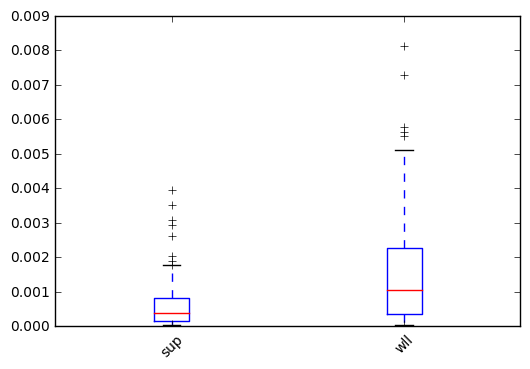

In [46]:
tag_list = ['sup', 'wll']
for i, tag in enumerate(tag_list):
    plt.scatter([i + 1]*n_sim, mse[tag], c=[i]*n_sim, s=10, cmap='copper')

plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
plt.axis('tight')
plt.ylim((0, plt.ylim()[1]))
plt.show(block=False)

plt.boxplot([mse[tag] for tag in tag_list])
plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
plt.show()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100

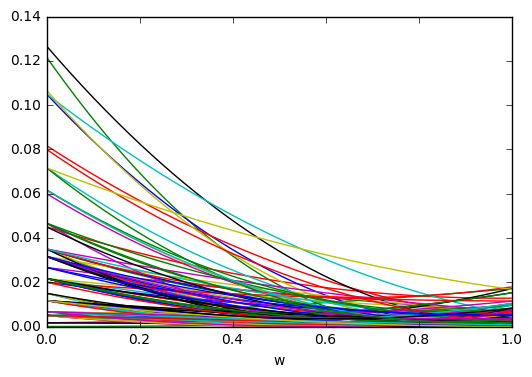

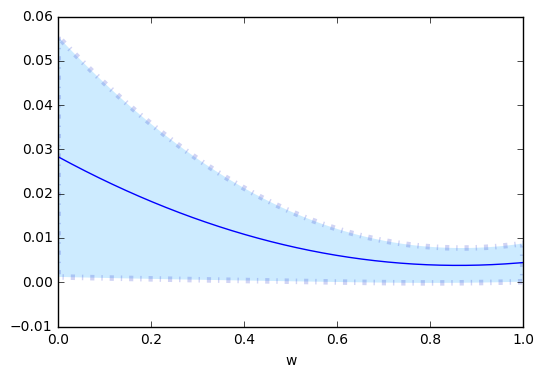

In [47]:
n_sim = 100
K = 50

mse = []
for n in range(n_sim):

    if (n+1)/1*1 == n+1:
        print str(n+1),

    # Generate fully labeled dataset
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I[iy]

    # Generate weakly labeled dataset
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    iz = wlw.generateWeak(iy, M, C)

    # Supervised estimation
    f = np.mean(y, axis=0)

    # Estimation with virtual labels
    # v = wlw.computeVirtual(iz, C, method='quasi_IPL')
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.mean(v, axis=0)
    
    w = np.arange(0, 1, 0.001)[:, np.newaxis]
    f_est = f * w + f_v * (1 - w)
    mse_n = np.mean((f_est - eta)**2, axis=1)
    mse.append(mse_n)

plt.plot(w.flatten(), np.array(mse).T)
plt.xlabel('w')
plt.show()

mse_mean =  np.mean(np.array(mse), axis=0)
mse_std = np.std(np.array(mse), axis=0)
plt.plot(w.flatten(), mse_mean)
plt.fill_between(w.flatten(), mse_mean - mse_std, mse_mean + mse_std,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)
plt.xlabel('w')
plt.show()


### 2.2. Optimal weight versus noise level

The following experiment shows that the relation between the noise level and the optimal weight might be non-trivial.

In [102]:
C = 3            # Number of classes
Ktrue = 10000       # Number of clean labels
Kweak = 10000       # Number of weak labels       
eta = np.array([0.5, 0.2, 0.3])   # True probability vector

beta_set = np.linspace(0, 1, 21)
n_sim = 10      # Number of experiments for each value of eta.
wmse = []
wkld = []
w = np.linspace(0, 1, 100)[:, np.newaxis]

for beta in beta_set:

    print "\rBeta = {0}".format(beta),
    
    # Mixing matrix
    M = wlw.computeM(C, beta=beta, method='noisy')

    # Compute virtual matrix (this is to compute virtual labels in a more efficient way
    # than the current implementation of ComputeVirtual in WLweakener)
    V = np.linalg.pinv(M)
    I = np.eye(M.shape[0])

    np.random.seed(0)
    mse = []
    kld = []
    for n in range(n_sim):

        # Generate fully labeled dataset
        iy = np.random.choice(np.arange(0, C), size=Ktrue, p=eta)
        y = I[iy]

        # Generate weakly labeled dataset
        iy = np.random.choice(np.arange(0, C), size=Kweak, p=eta)
        iz = wlw.generateWeak(iy, M, C)

        # Supervised estimation
        f = np.mean(y, axis=0)

        # Estimation with virtual labels
        # v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
        v = V.T[iz.astype(int)]
        f_v = np.mean(v, axis=0)
        
        if np.any(f_v<=0):
            print 
            print f_v

        # Weighted average
        f_est = f * w + f_v * (1 - w)
        mse_n = np.mean((f_est - eta)**2, axis=1)
        mse.append(mse_n)
        
        kld_n = - np.dot(eta, np.log(f_est.T)) 
        kld.append(kld_n)

    mse_mean =  np.mean(np.array(mse), axis=0)
    imin = np.argmin(mse_mean)
    wmse.append(w[imin])
    
    kld_mean =  np.mean(np.array(kld), axis=0)
    imin = np.argmin(kld_mean)
    wkld.append(w[imin])

Beta = 0.65 [[ 27. -13. -13.]
 [-13.  27. -13.]
 [-13. -13.  27.]]
[ 0.668 -0.048  0.38 ]


/Users/jcid/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in log


[[ 27. -13. -13.]
 [-13.  27. -13.]
 [-13. -13.  27.]]
[ 0.464 -0.032  0.568]
[[ 27. -13. -13.]
 [-13.  27. -13.]
 [-13. -13.  27.]]
[ 0.732 -0.036  0.304]
Beta = 1.0


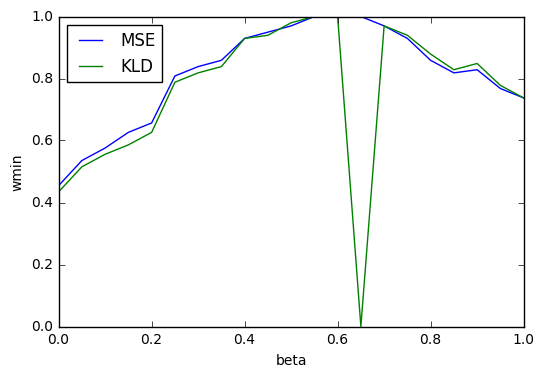

In [105]:
plt.plot(beta_set, np.array(wmse).flatten(), label="MSE")
plt.plot(beta_set, np.array(wkld).flatten(), label="KLD")
plt.xlabel('beta')
plt.ylabel('wmin')
plt.legend(loc='best')
plt.show()

The last experiment shows several important issues:

* The optimal weights could be independent on the choice of the proper loss
* The average of the virtual labels can be out of the probability simplex. In this respect, the optimal probability estimate should be computed with the constraint that the estimate lies inside the probability simplex. (Negative values are the cause of the anomalies in the KL divergence weighs).


### 2.3. A comparison between EM, virtual labels and the optimal weights

In [36]:
C = 3            # Number of classes
Ktrue = 1000       # Number of clean labels
Kweak = 1000       # Number of weak labels       
eta = np.array([0.5, 0.2, 0.3])   # True probability vector

beta_set = np.linspace(0, 1, 21)
n_sim = 10      # Number of experiments for each value of eta.
wmse = []
w = np.linspace(0, 1, 100)[:, np.newaxis]

mse_w = []
mse_v = []
mse_EM = []

for beta in beta_set:

    print "\rBeta = {0}".format(beta),
    
    # Mixing matrix
    M = wlw.computeM(C, beta=beta, method='noisy')

    # Compute virtual matrix (this is to compute virtual labels in a more efficient way
    # than the current implementation of ComputeVirtual in WLweakener)
    V = np.linalg.pinv(M)
    I = np.eye(M.shape[0])

    # Compute combined mixing matrix
    M2 = np.vstack((np.eye(C), M))
    V2 = np.linalg.pinv(M2)
    I2 = np.eye(M2.shape[0])
    
    np.random.seed(0)
    mse_wn = []
    mse_vn = []
    for n in range(n_sim):

        # #########################################
        # ## Weighted combination of virtual labels
        
        # Generate fully labeled dataset
        iy = np.random.choice(np.arange(0, C), size=Ktrue, p=eta)
        y = I[iy]

        # Generate weakly labeled dataset
        iy = np.random.choice(np.arange(0, C), size=Kweak, p=eta)
        iz = wlw.generateWeak(iy, M, C)

        # Supervised estimation
        f = np.mean(y, axis=0)

        # Estimation with virtual labels
        # v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
        v = V.T[iz.astype(int)]
        f_v = np.mean(v, axis=0)
        
        # Weighted average
        f_est = f * w + f_v * (1 - w)
        mse_wn.append(np.mean((f_est - eta)**2, axis=1))

        # #########################################
        # ## Weighted combination of virtual labels

        # Generate fully labeled dataset
        iy2 = np.hstack((iy, iz + c))
        iz2 = wlw.generateWeak(iy, M2, C)

        # Estimation with virtual labels
        v2 = V2.T[iz.astype(int)]
        f_v2 = np.mean(v2, axis=0)
        
        # Weighted average
        mse = np.mean((f_v2 - eta)**2, axis=1)
        mse_vn.append(mse)


        
        
    mse_mean =  np.mean(np.array(mse), axis=0)
    imin = np.argmin(mse_mean)
    wmse.append(w[imin])
    mse_w.append(np.min(msse_mean))
    

    

    

Beta = 0.0

NameError: name 'c' is not defined